
# Project: Investigate a Dataset - Movie Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

From the options given for this project I have selected the "TMDB" dataset, which contains data about over ten thousand movies released between 1960 and 2015. Most people have some knowledge and opinions about movies, and this dataset contains a lot of interesting information that can be used for some simple analysis and for more complicated questions that I hope I can raise at a later time.

The questions I will try to answer for this project are:

**Are certain genres associated with higher revenue?**

**Are there any trends in profitability of movies over the years?**

**Is there any correlation between viewer ratings and revenue?**

In [31]:
# First I import the libraries I will be using for this project.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The dataset is contained in one .csv file and the field that will require the most cleaning in order to be usable for my purposes is the 'genres'.
Since I intend to analyze only reasonably popular movies with many viewer votes, the rest of the cleaning will involve mostly filtering out movies which have either too few votes, too low budgets or missing budget and revenue data.

### General Properties

In [32]:
# I load the original dataset and do some initital exploration of its properties.

original_df = pd.read_csv('tmdb-movies.csv')
original_df.shape, original_df.isnull().sum()

((10866, 21), id                         0
 imdb_id                   10
 popularity                 0
 budget                     0
 revenue                    0
 original_title             0
 cast                      76
 homepage                7930
 director                  44
 tagline                 2824
 keywords                1493
 overview                   4
 runtime                    0
 genres                    23
 production_companies    1030
 release_date               0
 vote_count                 0
 vote_average               0
 release_year               0
 budget_adj                 0
 revenue_adj                0
 dtype: int64)

In [33]:
original_df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


### Data Cleaning
I will first have to get rid of the columns I will not use, and later do some work on the 'genres' column in order to simplify it to one genre per element.

#### 1. Removing columns that I don't need
The main independent variables I want to use are the release year and the genre, and the main dependent variables the viewer rating and the revenue. Regarding the budget and revenue, I will work with the columns adjusted to 2010 dollars so that movies accross different years are comparable.
The analysis I want to make is fairly simple but I want to keep some text columns such as the cast and director in case later on I want to come back to this dataset.

In [34]:
# I choose which columns I want to keep for my analysis, and use a list comprehension to produce a list with
# the rest of the columns. I create a new DataFrame droppping those columns from the original one.

drop_columns = [x for x in list(original_df.columns) if x not in ['original_title', 'cast',
'director', 'production_companies', 'runtime', 'genres', 'release_year',
'vote_count', 'vote_average', 'budget_adj', 'revenue_adj']]

less_cols_df = original_df.drop(drop_columns, axis=1)
less_cols_df.shape, less_cols_df.isnull().sum()

((10866, 11), original_title             0
 cast                      76
 director                  44
 runtime                    0
 genres                    23
 production_companies    1030
 vote_count                 0
 vote_average               0
 release_year               0
 budget_adj                 0
 revenue_adj                0
 dtype: int64)

I want to **add a column computing the revenue to budget ratio** for each movie, and also get an idea of the values in the columns I kept.

In [35]:
# Add the last column I need and get some basic statistics on the numeric fields.

less_cols_df['rev_to_budg_ratio'] = less_cols_df['revenue_adj'] / less_cols_df['budget_adj']
less_cols_df.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04,6165.000000
mean,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07,inf
std,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08,NaN
min,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00,0.000000
25%,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00,0.138804
50%,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00,1.898151
75%,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07,6.788662
max,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09,inf


#### 2. Removing rows with missing or useless values in the fields most relevant to the questions 
I see values of 0 where there should not be, in the fields runtime, budget and revenue.
I also notice that the mean vote count is over 200 votes, but half of the 10866 movies have under 40 votes.
I will first of all **drop movies with missing runtime data or a runtime under 40 minutes**, the minimum runtime to be considered a [feature film](https://en.wikipedia.org/wiki/Feature_film).

In [36]:
# Use boolean indexing to reduce the DataFrame based on movie runtime.

featurefilm_df = less_cols_df[less_cols_df['runtime'] >= 40]
featurefilm_df.shape

(10616, 12)

Then I **drop rows with budget or revenue equal to zero**.

In [37]:
# I drop rows with zero or missing values in key fields, then look at the numbers before I refine the trimming.

featurefilm_df = featurefilm_df.drop(featurefilm_df[(featurefilm_df.budget_adj == 0)
                                                    | (featurefilm_df.revenue_adj == 0)].index)
featurefilm_df.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,3853.000000,3853.000000,3853.000000,3853.000000,3.853000e+03,3.853000e+03,3.853000e+03
mean,109.261874,527.858552,6.167376,2001.267584,4.425756e+07,1.370886e+08,2.981166e+02
std,19.824089,880.029748,0.794933,11.281045,4.480587e+07,2.161343e+08,1.644469e+04
min,42.000000,10.000000,2.200000,1960.000000,9.693980e-01,2.370705e+00,2.400000e-07
25%,95.000000,71.000000,5.700000,1995.000000,1.309053e+07,1.834173e+07,8.764363e-01
50%,106.000000,204.000000,6.200000,2004.000000,3.001664e+07,6.174274e+07,2.119489e+00
75%,119.000000,580.000000,6.700000,2010.000000,6.061307e+07,1.632752e+08,4.209586e+00
max,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09,1.018619e+06


I see that three quarters of the movies have a budget over ten million dollars; I want to leave in movies with relatively low budget but if possible I want to avoid outliers in the revenue-to-budget-ratio so I will **filter out movies with budgets under 100,000 dollars**.
I also see that after my previous filters the mean vote count per movie is over 500, and half the movies have over 200 votes. I will **filter out movies with less than 100 votes** so as to have relevant viewer votes on popular movies.

In [38]:
# I use the statistics above to decide what the last numeric value filters should be, and apply them.

featurefilm_df = featurefilm_df.drop(featurefilm_df[(featurefilm_df.budget_adj < 100000)
                                                    | (featurefilm_df.vote_count < 100)].index)
featurefilm_df.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,2595.000000,2595.000000,2595.000000,2595.000000,2.595000e+03,2.595000e+03,2.595000e+03
mean,110.900578,759.628131,6.314374,2003.033911,5.417557e+07,1.871120e+08,5.532019e+00
std,19.686227,992.242884,0.751671,10.638140,4.825269e+07,2.449999e+08,1.609172e+01
min,42.000000,100.000000,3.300000,1960.000000,1.500779e+05,2.861934e+00,3.333333e-07
25%,97.000000,197.500000,5.800000,1998.000000,1.963068e+07,4.320802e+07,1.414221e+00
50%,107.000000,389.000000,6.300000,2006.000000,3.862322e+07,1.042663e+08,2.654928e+00
75%,121.000000,855.000000,6.800000,2011.000000,7.505533e+07,2.303185e+08,4.897737e+00
max,216.000000,9767.000000,8.400000,2015.000000,3.683713e+08,2.827124e+09,4.205227e+02


#### 3. Simplifying the values in the 'genres' column
This step involves some subjectivity in delimiting the most popular genres from a column that names several genres per movie, however I feel that it will be suitable for the purposes of this project.

I will write a function with a series of if / elif statements where a genre being higher in the function means that this genre is given preference if grouped together with other genres for a movie.

**If a movie's genre falls into one of the if / elif filters then the following elif statements are ignored; if none of these filters can assign a genre for a movie then the first genre name in the original 'genres' column is chosen**.

While this method has limitations, hopefully most moviegoers will find it adequate for a simple analysis.

In [39]:
# If a movie's genre falls into one of the if / elif filters then the following elif statements are ignored;
# if none of these filters can assign a genre for a movie,
# then the first genre name in the original 'genres' column is chosen.

def genre_cleaner(g):
    if 'Animation' in g:
        g = 'Animation'
    elif 'Science Fiction' in g:
        g = 'Science Fiction'
    elif 'Horror' in g and 'Comedy' in g:
        g = 'Comedy'
    elif 'Horror' in g:
        g = 'Horror'
    elif 'Fantasy' in g:
        g = 'Fantasy'
    elif 'Family' in g:
        g = 'Family'
    elif 'Crime' in g and 'Comedy' in g:
        g = 'Crime_Comedy'
    elif ('Drama' in g or 'Romance' in g) and 'Comedy' in g:
        g = 'Drama_Comedy'
    elif 'Thriller' in g and 'Crime' in g:
        g = 'Crime_Thriller'
    elif 'Thriller' in g:
        g = 'Thriller'
    elif 'Drama' in g or 'Romance' in g:
        g = 'Drama'
    elif 'Comedy' in g:
        g = 'Comedy'
    elif 'War' in g and 'Comedy' in g:
        g = 'Comedy'
    else:
        g = g.split('|')[0]
    return g

featurefilm_df['genre_clean'] = featurefilm_df['genres'].apply(genre_cleaner)
featurefilm_df.genre_clean.value_counts()

Drama              430
Science Fiction    376
Drama_Comedy       270
Crime_Thriller     244
Comedy             234
Thriller           233
Horror             212
Fantasy            194
Animation          168
Crime_Comedy        90
Family              74
Action              39
Adventure           13
Documentary          6
Western              5
War                  3
Music                2
History              1
Crime                1
Name: genre_clean, dtype: int64

\*After a good deal of trial and error with the genre_cleaner function, I keep separate *Crime_Thriller* and *Crime_Comedy* genres due to their popularity (in terms of total movies). Similarly *Drama_Comedy* is a genre many movies fall into, while there would be relatively very few movies of the genres *Horror_Comedy* or *War_Comedy* if I were to maintain those genres separate from *Comedy*.

In order to keep only relevant categories, I will **drop the movies representing a genre which contributes less than 1% of all the movies** in the cleaned dataframe.

In [40]:
# I use a list comprehension to crete a list of the genres represented in
# less than 1% of total movies, then drop the movies classified in those genres.

genre_counts = dict(featurefilm_df.genre_clean.value_counts())
drop_genres = [key for key in genre_counts if genre_counts[key] < featurefilm_df.shape[0]/100]

clean_df = featurefilm_df.drop(featurefilm_df[featurefilm_df['genre_clean'].isin(drop_genres)].index)
clean_df.genre_clean.value_counts()

Drama              430
Science Fiction    376
Drama_Comedy       270
Crime_Thriller     244
Comedy             234
Thriller           233
Horror             212
Fantasy            194
Animation          168
Crime_Comedy        90
Family              74
Action              39
Name: genre_clean, dtype: int64

In [43]:
# Calculate the total distinct genres and the final shape of my clean dataset.

clean_df.genre_clean.value_counts().count()

12

In [44]:
clean_df.shape

(2564, 13)

**After cleaning the dataset, I have data on 2564 movies**.

There are 12 distinct genres in the clean dataframe.



<a id='eda'></a>



## Exploratory Data Analysis


### 1. Are certain genres associated with higher revenue?
I first group the rows by genre to look for patterns, then plot a chart to look at the revenue to budget ratio.

In [45]:
# A quick look at numerical values accross genres.

clean_df.groupby('genre_clean').mean()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
genre_clean,,,,,,,
Action,115.000000,824.769231,6.015385,2004.615385,7.153637e+07,1.556115e+08,2.516584
Animation,90.708333,1052.994048,6.488690,2004.839286,9.340377e+07,3.396683e+08,4.664485
Comedy,99.119658,492.739316,5.945726,2004.619658,3.573062e+07,1.137687e+08,5.029146
Crime_Comedy,106.833333,646.811111,6.318889,2001.755556,4.889925e+07,1.586179e+08,4.894770
Crime_Thriller,114.668033,726.893443,6.427049,2003.750000,4.803865e+07,1.373060e+08,3.502584
Drama,125.427907,613.267442,6.785116,2002.490698,3.861097e+07,1.358921e+08,5.121482
Drama_Comedy,107.666667,487.125926,6.357407,2003.507407,3.461531e+07,1.407930e+08,6.260205
Family,104.472973,344.162162,6.032432,2002.675676,4.371838e+07,1.684016e+08,4.500541
Fantasy,114.030928,1145.164948,6.211340,2003.422680,9.231908e+07,3.048120e+08,3.478780


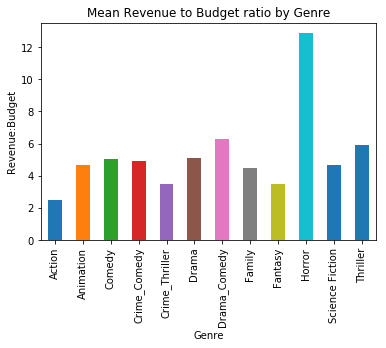

In [46]:
# I notice substantial differences in the mean revenue-to-budget-ratio and make a visualization.

clean_df.groupby('genre_clean')['rev_to_budg_ratio'].mean().plot(kind='bar')
plt.ylabel('Revenue:Budget')
plt.xlabel('Genre')
plt.title('Mean Revenue to Budget ratio by Genre');

**The *Horror* genre clearly stands above all the rest when it comes to mean revenue-to-budget ratio, however *Horror* movies also seem to have lower budgets and lower revenue on average**.


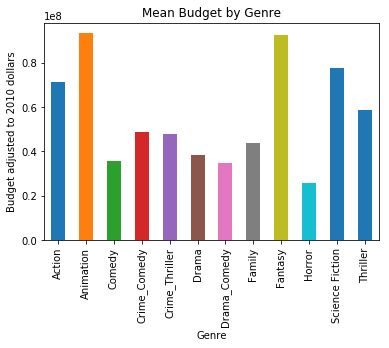

In [47]:
# I also want a visualization of the fields making up said ratio to see if contrasts look equally sharp.

clean_df.groupby('genre_clean')['budget_adj'].mean().plot(kind='bar')
plt.ylabel('Budget adjusted to 2010 dollars')
plt.xlabel('Genre')
plt.title('Mean Budget by Genre');

A visual representation shows how the genres with higher revenue to budget ratios also tend to have lower budgets and lower revenue, however the differences between genres don't seem so sharp as in the previous chart.

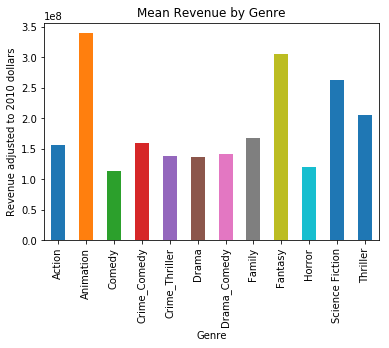

In [48]:
clean_df.groupby('genre_clean')['revenue_adj'].mean().plot(kind='bar')
plt.ylabel('Revenue adjusted to 2010 dollars')
plt.xlabel('Genre')
plt.title('Mean Revenue by Genre');

### 2. Are there any trends in the profitability of movies over the years?
First let's look at the numer of movies released each year that are present in our clean dataframe:

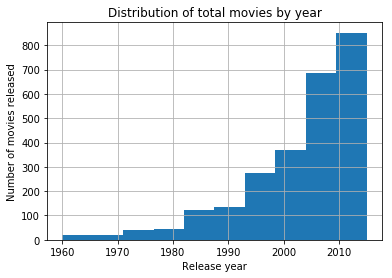

In [49]:
# Make a histogram to show trends in amount of released movies.

clean_df.release_year.hist()
plt.title('Distribution of total movies by year')
plt.xlabel('Release year')
plt.ylabel('Number of movies released');

Not surprisingly, **the majority of the popular movies in the dataset are more recent movies**.

Now looking at the mean revenue to budget ratio over time:

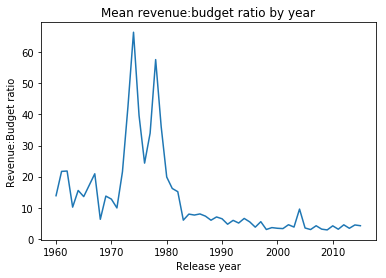

In [50]:
# Use a line chart to visualize changes in revenue-to-budget-ratio over time.

clean_df.groupby('release_year')['rev_to_budg_ratio'].mean().plot()
plt.title('Mean revenue:budget ratio by year')
plt.xlabel('Release year')
plt.ylabel('Revenue:Budget ratio');

It looks like **a lot of the revenue-to-budget-ratio outliers are older movies**.

Perhaps it would be useful to **separate the clean dataframe into one dataframe with the very high revenue-to-budget-ratio movies and another dataframe with regular revenue-to-budget-ratio movies**.

I will need some statistics to have an idea of where to make the distinction:

In [51]:
# Look at statistics to decide if dividing the dataset based in a certain category is necessary.

clean_df.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,2564.000000,2564.000000,2564.000000,2564.000000,2.564000e+03,2.564000e+03,2.564000e+03
mean,110.797192,760.394306,6.310062,2003.100624,5.400796e+07,1.862416e+08,5.509377e+00
std,19.722722,994.027968,0.751609,10.599178,4.805373e+07,2.446901e+08,1.615066e+01
min,42.000000,100.000000,3.300000,1960.000000,1.500779e+05,2.861934e+00,3.333333e-07
25%,97.000000,198.750000,5.800000,1998.000000,1.961990e+07,4.286806e+07,1.411633e+00
50%,107.000000,389.000000,6.300000,2006.000000,3.856969e+07,1.035956e+08,2.651167e+00
75%,121.000000,856.250000,6.800000,2011.000000,7.500745e+07,2.282461e+08,4.889847e+00
max,216.000000,9767.000000,8.400000,2015.000000,3.683713e+08,2.827124e+09,4.205227e+02


The rightmost column shows that, while 75% of the movies have a ratio under 5, the movie with the highest ratio has a value of 420. I will separate the dataframe into two groups, with a revenue to budget ratio below and above the value 15.

In [52]:
# Given the big disparities in revenue-to-budget-ratio I divide the working dataframe in two tiers
# using boolean indexing to crete two new dataframes, then look at the statistics for each.

regular_revratio = clean_df[clean_df.rev_to_budg_ratio < 15]
regular_revratio.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,2430.000000,2430.000000,2430.000000,2430.000000,2.430000e+03,2.430000e+03,2.430000e+03
mean,111.016049,755.004527,6.287737,2003.804527,5.611140e+07,1.716608e+08,3.302724e+00
std,19.772547,995.053704,0.743595,9.760663,4.834367e+07,2.171542e+08,2.838370e+00
min,42.000000,100.000000,3.300000,1960.000000,2.025573e+05,2.861934e+00,3.333333e-07
25%,97.000000,196.250000,5.800000,1999.000000,2.086353e+07,4.152604e+07,1.314994e+00
50%,107.000000,384.000000,6.300000,2006.000000,4.088444e+07,9.912859e+07,2.516416e+00
75%,121.000000,849.000000,6.800000,2011.000000,7.825941e+07,2.133481e+08,4.308782e+00
max,216.000000,9767.000000,8.400000,2015.000000,3.683713e+08,2.827124e+09,1.499825e+01


In [54]:
high_revratio = clean_df[clean_df.rev_to_budg_ratio >= 15]
high_revratio.describe()

,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,rev_to_budg_ratio
count,134.000000,134.000000,134.000000,134.000000,1.340000e+02,1.340000e+02,134.000000
mean,106.828358,858.134328,6.714925,1990.335821,1.586347e+07,4.506549e+08,45.525533
std,18.418088,973.705980,0.783429,15.866901,1.641014e+07,4.671792e+08,56.366709
min,78.000000,103.000000,4.500000,1960.000000,1.500779e+05,6.264208e+06,15.094022
25%,93.000000,272.000000,6.200000,1977.000000,4.184581e+06,1.223481e+08,19.743555
50%,106.000000,479.500000,6.800000,1990.000000,1.018808e+07,3.036885e+08,25.562337
75%,118.750000,1096.250000,7.300000,2004.000000,2.612849e+07,6.221083e+08,51.167037
max,181.000000,5343.000000,8.300000,2015.000000,7.195562e+07,2.789712e+09,420.522723


Looking at release year statistics, the mean release year of the 2,430 movies in the 'regular' group is 2003 while the mean release year of the 134 movies in the 'high' group is 1990.

Only about a quarter of the movies in the 'high' group were released after year 2000, while three quarters of the movies in the 'regular' group were released after 2000.

Showing the mean revenue to budget ratio of each group visually:

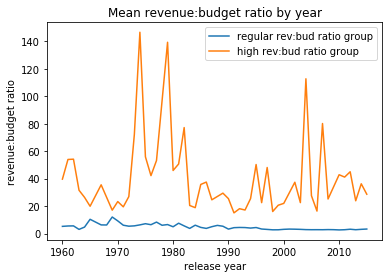

In [67]:
# I plot the Mean revenue:budget ratio by year again looking at the two tiers of movies separately.

regular_revratio.groupby('release_year')['rev_to_budg_ratio'].mean().plot(label='regular rev:bud ratio group'),
high_revratio.groupby('release_year')['rev_to_budg_ratio'].mean().plot(label='high rev:bud ratio group')
plt.title('Mean revenue:budget ratio by year')
plt.legend()
plt.xlabel('release year')
plt.ylabel('revenue:budget ratio');

The chart above does not show any apparent pattern in the 'high ratio' group. **The fact that there were far more movies released in recent years partly explains why most of the movies in the 'regular ratio' group were more recent movies**.

Going **back to the genre question**, it may be interesting to explore diferences in the distribution by genre and year of the 'regular ratio' and 'high ratio' groups:

In [58]:
# I look at statistics of each revenue:budget ratio tier,
# this time grouping by genre to look for patterns.

regular_revratio.groupby('genre_clean')['release_year'].describe()

,count,mean,std,min,25%,50%,75%,max
genre_clean,,,,,,,,
Action,38.0,2005.473684,11.412977,1960.0,2004.25,2007.5,2013.0,2015.0
Animation,161.0,2005.689441,7.909833,1970.0,2002.00,2007.0,2011.0,2015.0
Comedy,228.0,2004.951754,8.641787,1979.0,2001.00,2007.0,2012.0,2015.0
Crime_Comedy,85.0,2002.588235,8.936674,1980.0,1998.00,2003.0,2011.0,2015.0
Crime_Thriller,239.0,2004.213389,8.370144,1968.0,1999.00,2006.0,2011.0,2015.0
Drama,406.0,2003.278325,11.375472,1960.0,1998.25,2006.0,2012.0,2015.0
Drama_Comedy,251.0,2004.358566,9.592441,1960.0,2001.00,2007.0,2011.0,2015.0
Family,69.0,2003.927536,8.911854,1964.0,2001.00,2006.0,2010.0,2015.0
Fantasy,191.0,2003.748691,8.618199,1971.0,1999.50,2006.0,2010.0,2015.0


In [59]:
high_revratio.groupby('genre_clean')['release_year'].describe()

,count,mean,std,min,25%,50%,75%,max
genre_clean,,,,,,,,
Action,1.0,1972.000000,NaN,1972.0,1972.00,1972.0,1972.00,1972.0
Animation,7.0,1985.285714,18.391251,1961.0,1972.00,1991.0,1993.00,2015.0
Comedy,6.0,1992.000000,15.270887,1974.0,1980.00,1991.5,2002.25,2013.0
Crime_Comedy,5.0,1987.600000,15.978110,1973.0,1982.00,1984.0,1984.00,2015.0
Crime_Thriller,5.0,1981.600000,11.865918,1971.0,1973.00,1975.0,1994.00,1995.0
Drama,24.0,1989.166667,14.306176,1967.0,1976.75,1986.5,2003.25,2014.0
Drama_Comedy,19.0,1992.263158,12.524829,1967.0,1987.00,1996.0,2001.00,2012.0
Family,5.0,1985.400000,11.631853,1965.0,1987.00,1990.0,1992.00,1993.0
Fantasy,3.0,1982.666667,16.289056,1964.0,1977.00,1990.0,1992.00,1994.0


In the 'regular ratio' group, the mean release years are very similar accross all genres.

**However in the 'high ratio' group, the *Horror* genre has by far the most amount of movies and the most recent mean release year, and is the only genre in this group with over half its movies released after year 2000**.

### 3. Is there any correlation between viewer ratings and revenue?
If these two dependent variables have any correlation it should be easy to see with a scatterplot. Due to the presence of outliers in the revenue to budget ratio variable, it is preferable to compare the 'high ratio' and 'regular ratio' groups separately.

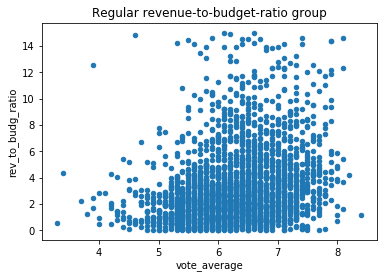

In [60]:
# I use scatterplots to look for correlation between the two dependent variables in the dataset.
# I plot the two revenue:budget ratio tiers separately for better 'resolution' within each group.

regular_revratio.plot(kind='scatter', x='vote_average', y='rev_to_budg_ratio')
plt.title('Regular revenue-to-budget-ratio group');

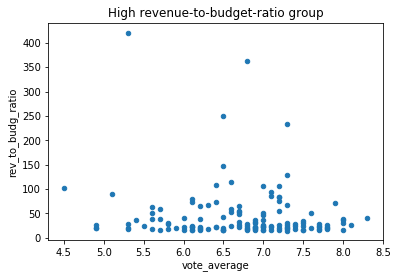

In [61]:
high_revratio.plot(kind='scatter', x='vote_average', y='rev_to_budg_ratio')
plt.title('High revenue-to-budget-ratio group');

It is possible to eliminate the furthest outliers from the 'high ratio' group to facilitate the visualization of patterns:

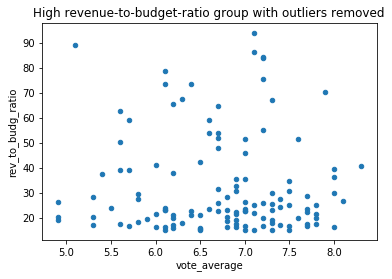

In [63]:
# With boolean indexing I create a new scatterplot of the 'high ratio' group without outliers.

cleaner_high_revratio = high_revratio[high_revratio.rev_to_budg_ratio < 100]
cleaner_high_revratio.plot(kind='scatter', x='vote_average', y='rev_to_budg_ratio')
plt.title('High revenue-to-budget-ratio group with outliers removed');

Looking at these charts, **there does not seem to be any correlation between high viewer ratings and a high revenue to budget ratio**.

We can lastly look at the mean viewer ratings by genre, next to the previous mean revenue-to-budget-ratio by genre chart, to try to find any patterns:

In [64]:
# Compute vote score statistics grouping by genre to look for any patterns.

clean_df.groupby('genre_clean')['vote_average'].describe()

,count,mean,std,min,25%,50%,75%,max
genre_clean,,,,,,,,
Action,39.0,6.015385,0.875557,4.3,5.400,6.10,6.6,7.7
Animation,168.0,6.488690,0.646448,5.1,6.000,6.50,6.9,8.0
Comedy,234.0,5.945726,0.724319,3.3,5.500,6.00,6.4,7.5
Crime_Comedy,90.0,6.318889,0.638097,5.0,6.000,6.30,6.7,7.9
Crime_Thriller,244.0,6.427049,0.693181,4.4,6.000,6.40,7.0,8.1
Drama,430.0,6.785116,0.633422,4.7,6.400,6.80,7.2,8.4
Drama_Comedy,270.0,6.357407,0.629451,4.5,5.900,6.30,6.8,8.1
Family,74.0,6.032432,0.652101,4.5,5.525,5.95,6.5,7.7
Fantasy,194.0,6.211340,0.777651,4.0,5.700,6.20,6.7,8.0


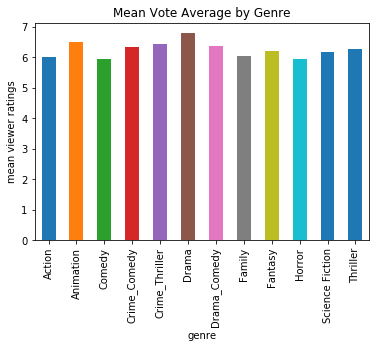

In [65]:
# Since genres showed a clear disparity in mean revenue:budget ratio, I plot a similar chart
# of mean vote scores by genre to compare these variables visually.

clean_df.groupby('genre_clean')['vote_average'].mean().plot(kind='bar')
plt.ylabel('mean viewer ratings')
plt.xlabel('genre')
plt.title('Mean Vote Average by Genre');

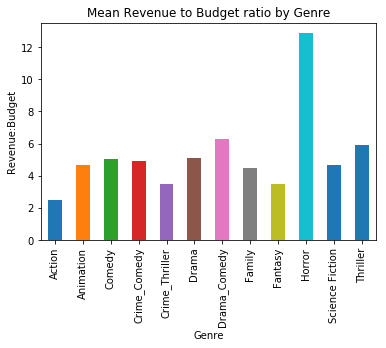

In [66]:
clean_df.groupby('genre_clean')['rev_to_budg_ratio'].mean().plot(kind='bar')
plt.ylabel('Revenue:Budget')
plt.xlabel('Genre')
plt.title('Mean Revenue to Budget ratio by Genre');

<a id='conclusions'></a>
## Conclusions

The analysis performed on data about 2,564 movies suggests that:

1. Movies of the *Horror* genre seem to be to some extent associated to a higher ratio of revenue to budget, due to generally having lower budgets compared to other genres while still having many outlier movies with exceptionally high revenue to budget ratios, especially among more recent movies and compared to other genres.

2. Older movies are more represented among the outliers with very high revenue to budget ratios, but this seems to be due in part to far more movies being released in more recent years while the amount of high revenue-to-budget-ratio outliers stays consistent.

3. There seems to be no correlation whatsoever between viewer ratings and revenue-to-budget-ratio, and mean viewer ratings show virtually no difference accross genres.

#### Limitations of the analysis performed
The conclusions expressed above come from analyzing around a quarter of the total movies in the original dataset.
There may have been movies excluded from the analysis that had characteristics comparable to those analyzed but were dropped due to having missing or erroneous values in fields such as budget and revenue.
There may be categorical data other than genre that are also related with the revenue or viewer scores of a movie but were not analyzed for this project, such as the cast, director or production companies.
Finally, the average vote score of a movie in the original dataset is not necessarily an accurate representation of how much viewers in general enjoy or are likely to enjoy said movie, rather it's a measure of how users of a particular website rated this particular movie.
